## MAIZSIM sims - present

In [ ]:
import os
import yaml

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from SALib.analyze import rbd_fast
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype import DATA_PATH

In [2]:
%%time
df_sims, df_issues = read_sims('/home/disk/eos8/ach315/upscale/sims/present')
#df_sims.to_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_present.csv', index=False)

CPU times: user 28.5 s, sys: 19 s, total: 47.5 s
Wall time: 20min 35s


In [4]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

In [5]:
print(df_matured.shape[0]/df_all.shape[0])
print(df_extended.shape[0]/df_all.shape[0])
print(df_stuck.shape[0]/df_all.shape[0])

0.9354487760652765
0.03699002719854941
0.02756119673617407


### Summary plots

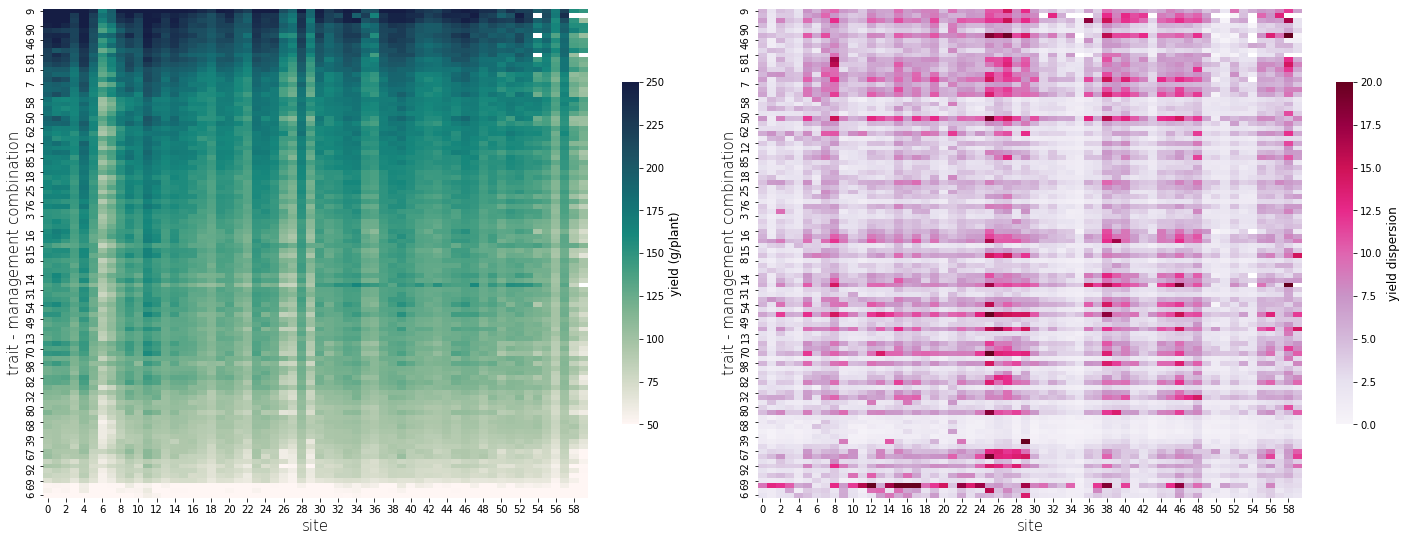

In [12]:
# Aggregate data
df = df_matured
groups = ['cvar', 'site']
mx_mean = agg_sims(df, groups, 'mean')
mx_variance = agg_sims(df, groups, 'variance')
mx_disp = np.divide(mx_variance, mx_mean)
df_yield_means = pd.DataFrame(mx_mean)
df_yield_vars = pd.DataFrame(mx_disp)

# Sort data based on mean yield value
df_yield_means['mean'] = df_yield_means.mean(axis=1)
index_sortbymean = df_yield_means.sort_values(by=['mean'], axis=0, ascending=False).index

# Drop last column of calculated mean for plotting purpose
df_yield_means = df_yield_means.iloc[:,:-1]

# Data for plotting
dfs = [df_yield_means, df_yield_vars]
dfs = [df_yield_means, df_yield_vars]
cmaps = [Tempo_10.mpl_colormap, 'PuRd']
vmins = [50, 0]
vmaxs = [250, 20]
labels = ['yield (g/plant)', 'yield dispersion']

# Figure
fig = plt.figure(figsize=(25,9))
for index, df, cmap, vmin, vmax, label in zip([1,2], dfs, cmaps, vmins, vmaxs, labels):
    ax = fig.add_subplot(1,2,index)
    hm = sns.heatmap(df.reindex(index_sortbymean), cmap=cmap, 
                cbar_kws={'shrink': 0.7}, vmin=vmin, vmax=vmax)
    ax.set_xlabel('site', size=15, fontweight='light')
    ax.set_ylabel('trait - management combination', size=15, fontweight='light')
    ax.figure.axes[-1].set_ylabel(label, size=12)

fig.subplots_adjust(wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_mean_var.png', format='png', dpi=800)

Text(0.5, 1.0, 'extended gseason')

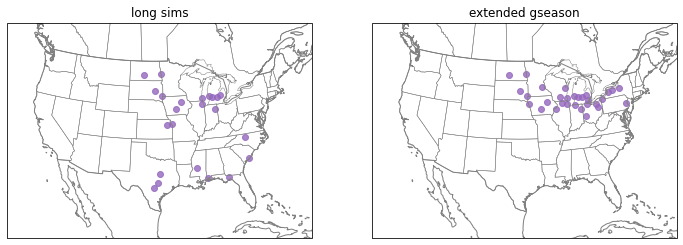

In [13]:
lat_stuck = df_stuck.groupby('site').mean().lat
lon_stuck = df_stuck.groupby('site').mean().lon
lat_extend = df_extended.groupby('site').mean().lat
lon_extend = df_extended.groupby('site').mean().lon

fig = plt.figure(figsize=(12,5))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax1.scatter(lon_stuck, lat_stuck, transform=ccrs.PlateCarree(), c='tab:purple', alpha=0.8)
ax1.set_extent(extent)
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('long sims')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax2.scatter(lon_extend, lat_extend, transform=ccrs.PlateCarree(), c='tab:purple', alpha=0.8)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('extended gseason')

Text(0.5, 1.0, 'mean simulated rainfed yield (tons/ha)')

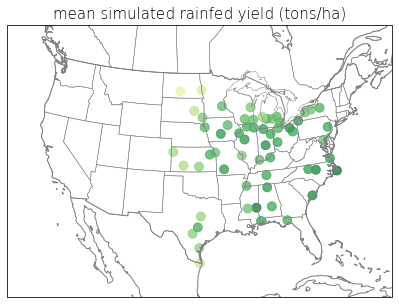

In [14]:
# Upscale yield from plant level (g/plant) to field level (tons/ha)
pop = 8  # plants/m2
ha_to_m2 = 10000
ton_to_g = 907185
ear_to_yield = 0.86  # only portion of ear converts into yield

# Visualize
fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
df_sub = df_all.groupby('site').mean()
sim_yield = [(ha_to_m2*pop*ear*ear_to_yield)/ton_to_g for ear in df_sub.dm_ear]

ax.scatter(df_sub.lon, df_sub.lat, 
           c=sim_yield, 
           cmap=YlGn_9.mpl_colormap,
           transform=ccrs.PlateCarree(), alpha=0.8, s=80,
           vmin=5, vmax=14)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('mean simulated rainfed yield (tons/ha)', fontsize=15, fontweight='light')

Text(0, 0.5, 'Yield (g/plant)')

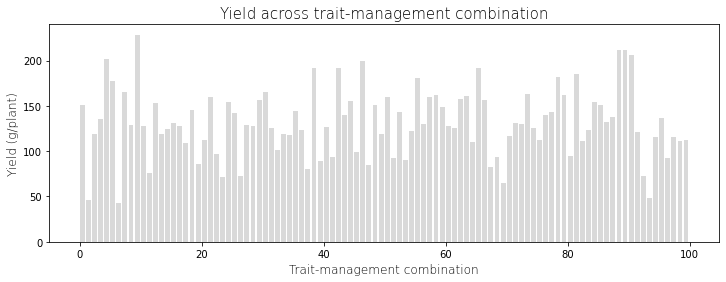

In [15]:
pheno_yield = df_all.groupby('cvar').mean().dm_ear
x = np.arange(len(pheno_yield))
width = 0.8

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
ax.bar(x+width/2, pheno_yield, width, color='#d9d9d9')
ax.set_title('Yield across trait-management combination', fontweight='light', fontsize=15)
ax.set_xlabel('Trait-management combination', fontweight='light', fontsize=12)
ax.set_ylabel('Yield (g/plant)', fontweight='light', fontsize=12)

Text(0, 0.5, 'Yield (g/plant)')

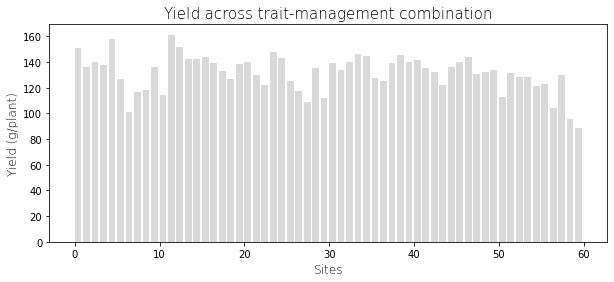

In [16]:
pheno_yield = df_all.groupby('site').mean().dm_ear
x = np.arange(len(pheno_yield))
width = 0.8

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.bar(x+width/2, pheno_yield, width, color='#d9d9d9')
ax.set_title('Yield across trait-management combination', fontweight='light', fontsize=15)
ax.set_xlabel('Sites', fontweight='light', fontsize=12)
ax.set_ylabel('Yield (g/plant)', fontweight='light', fontsize=12)

### Mean yield maps of all cultivars

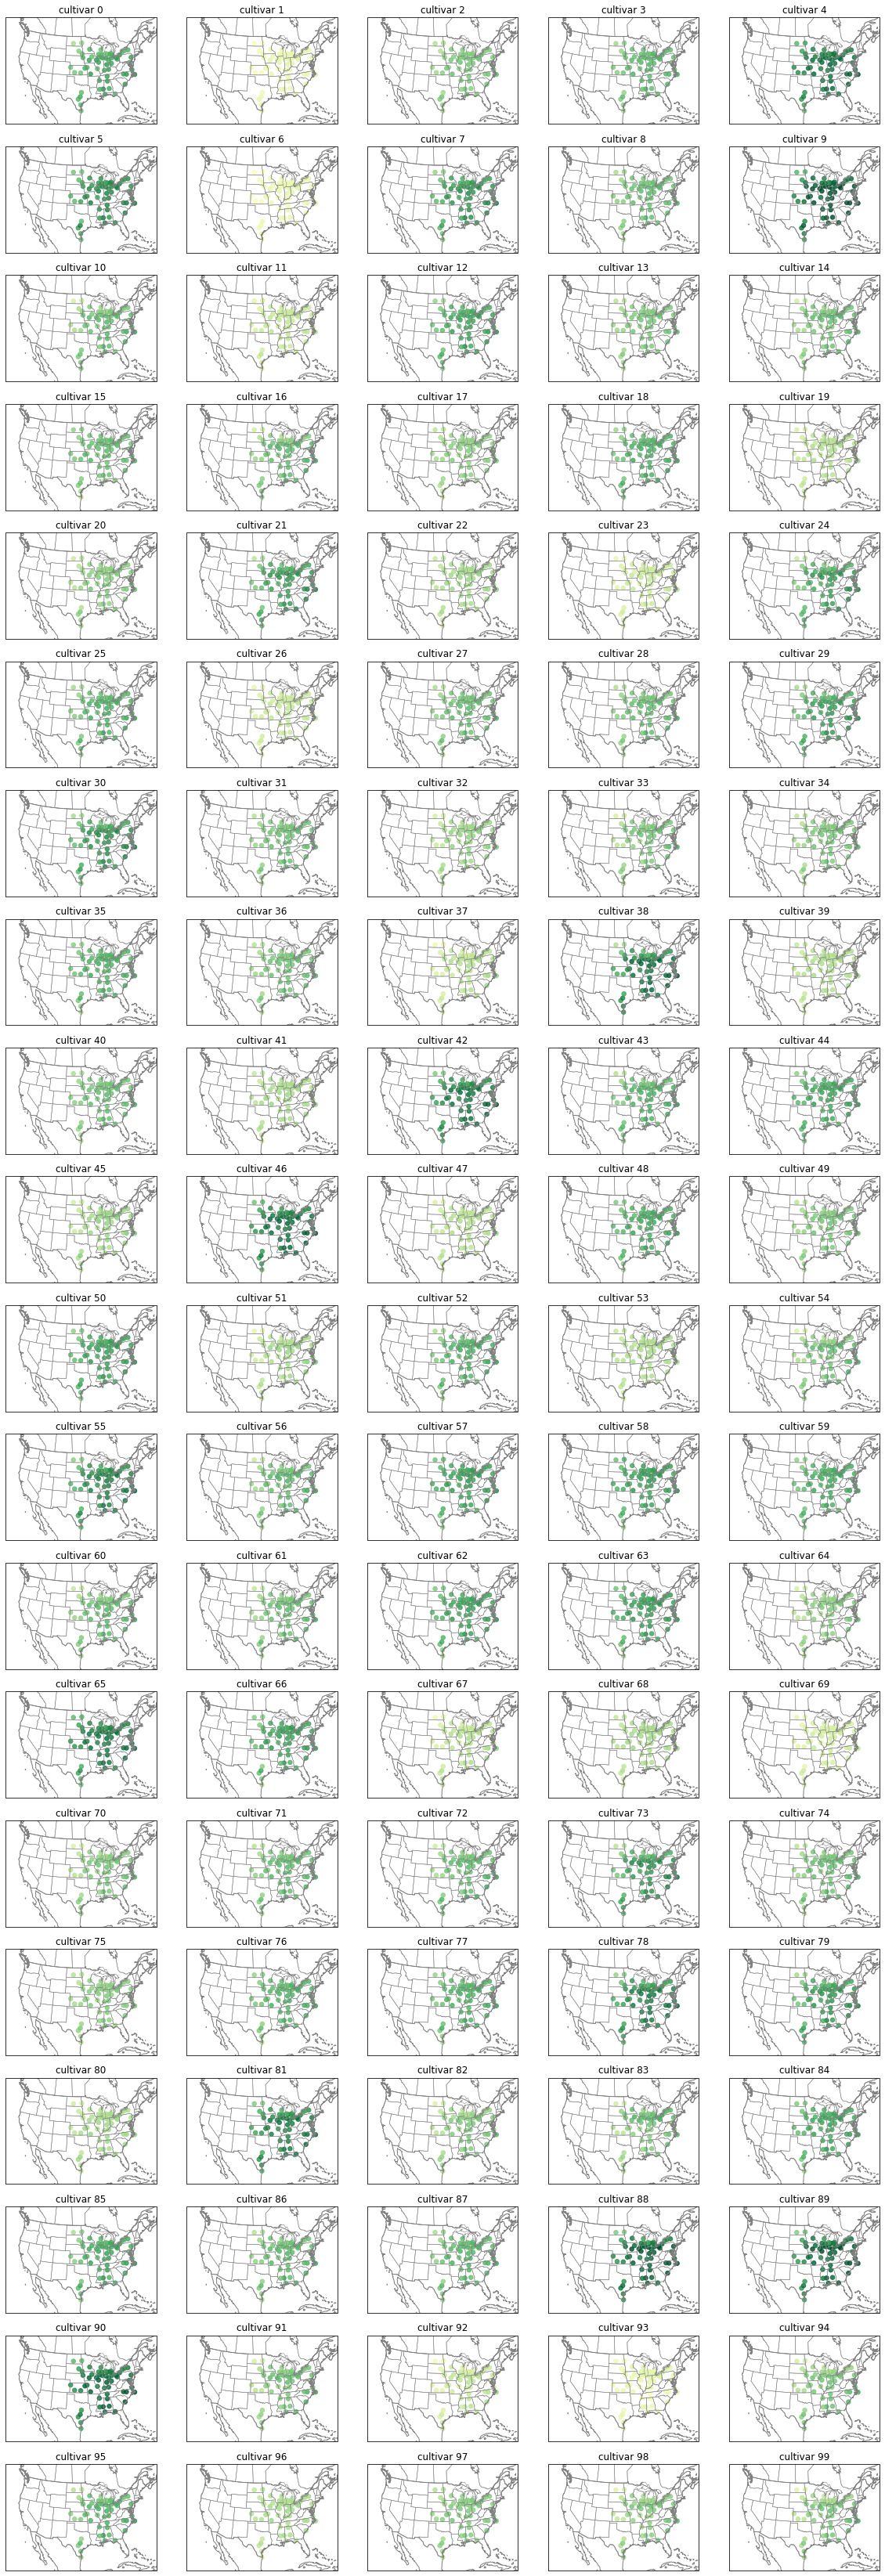

In [17]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(20,60))

for cvar in np.arange(100):
    ax = fig.add_subplot(20,5,cvar+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=0, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))

## Mean yield in climate space

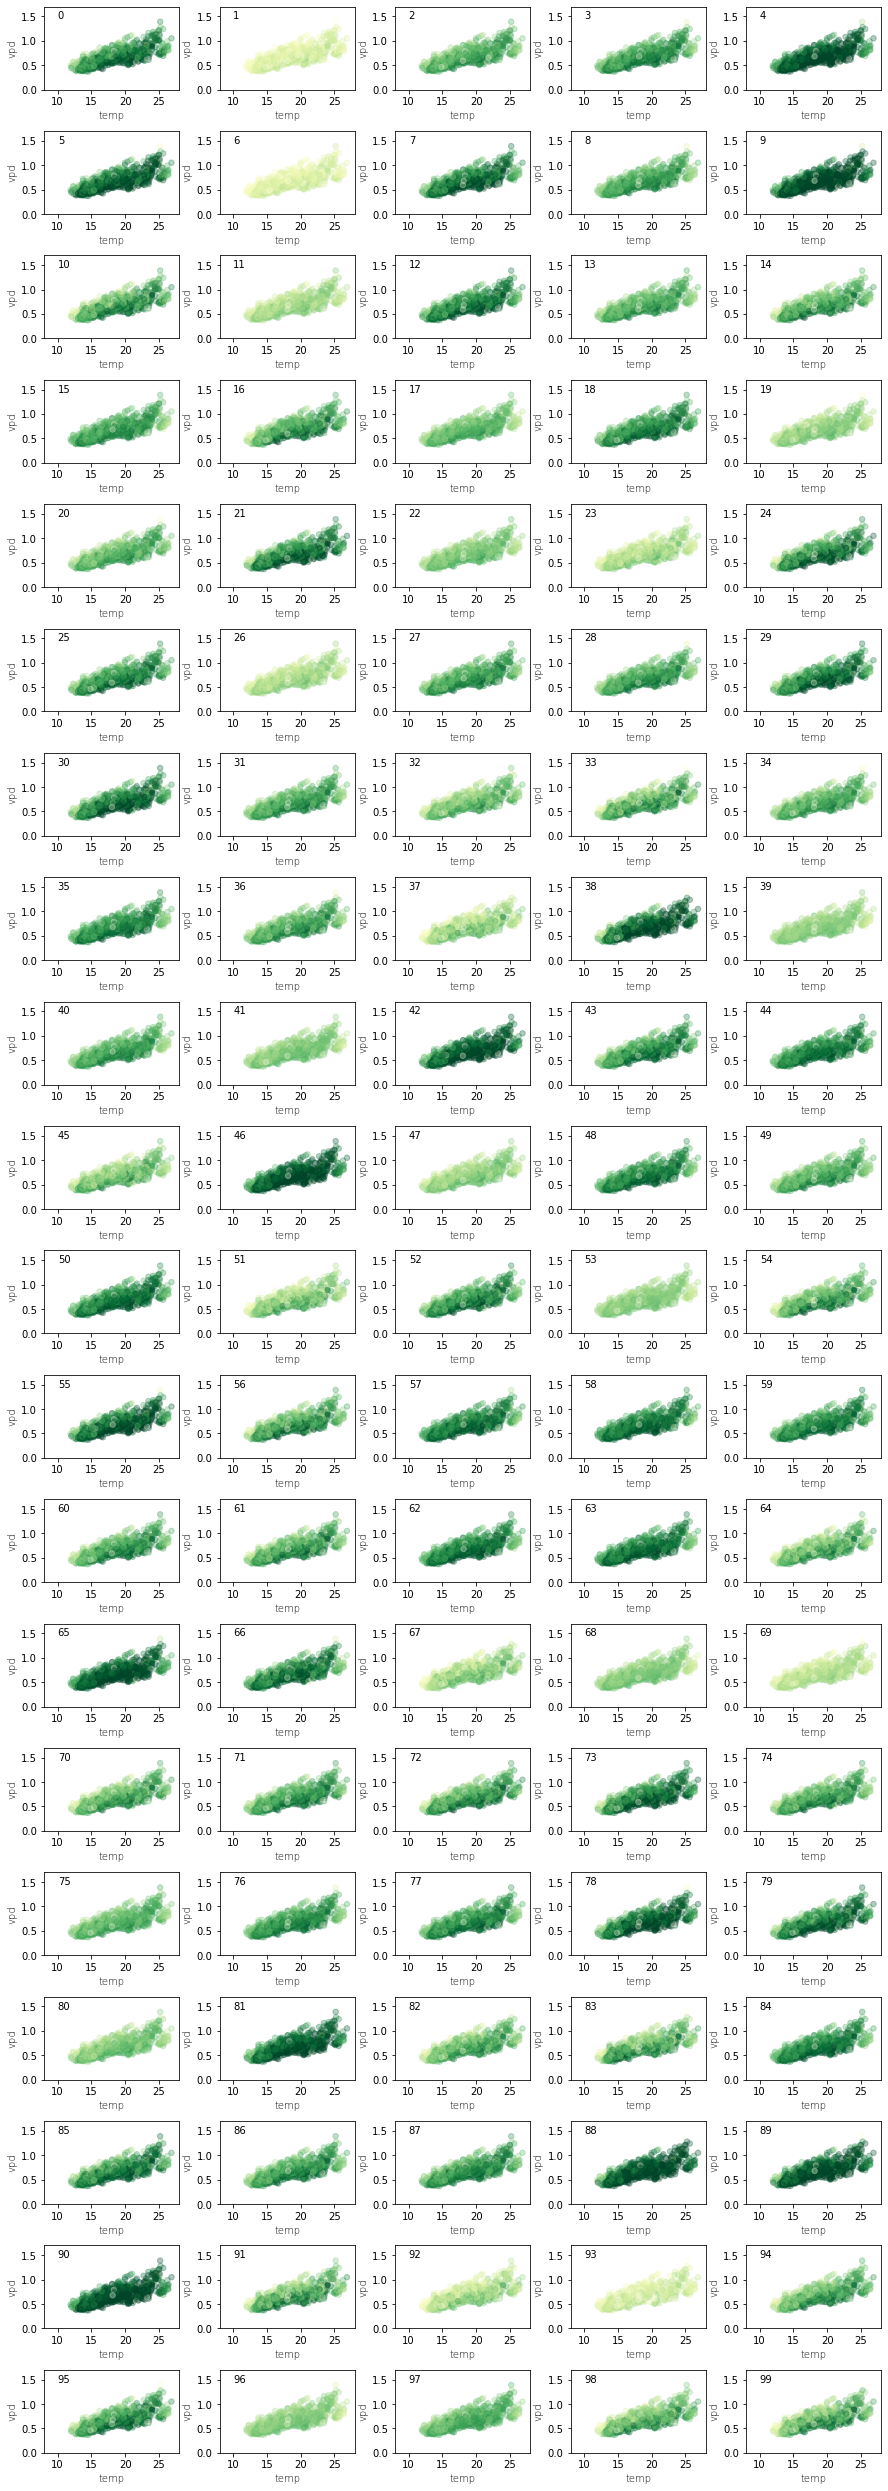

In [18]:
cvars = np.arange(100)

fig, axs = plt.subplots(20, 5, figsize=(15, 45))
for ax, cvar in zip(axs.flatten(), cvars):
    df = df_all.query(f'cvar=={cvar}')
    sc = ax.scatter(df.temp, df.vpd, 
                    c=df.dm_ear, cmap=YlGn_9.mpl_colormap,
                    vmin=0, vmax=200, alpha=0.3, s=30)
    ax.set_xlim(8,28)
    ax.set_ylim(0,1.7)
    ax.set_xlabel('temp', fontweight='light')
    ax.set_ylabel('vpd', fontweight='light')
    ax.text(10,1.45,cvar)
#    cbar = fig.colorbar(sc, ax=ax, shrink=0.6)

fig.subplots_adjust(wspace=0.3, hspace=0.5)